In [1]:
import numpy as np
from sklearn.metrics import mean_squared_error
from sklearn.datasets import make_regression
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
import random
import pandas as pd
import time

In [2]:
X, Y, coef = make_regression(n_samples=1000, n_features=5, n_informative=2, coef=True, random_state=42)
print(f'Истинные значения коэффициентов: {coef}')

Истинные значения коэффициентов: [16.82365791 18.99347437  0.          0.          0.        ]


In [3]:
print(f'Стандартное отклонение признаков до стандартизации: {X.std()}')
X = StandardScaler().fit_transform(X)
print(f'Стандартное отклонение признаков после стандартизации: {X.std()}')

Стандартное отклонение признаков до стандартизации: 0.996380175855159
Стандартное отклонение признаков после стандартизации: 0.9999999999999998


### 1. Напишите функцию наподобие gradient_descent_reg_l2, но для применения L1-регуляризации.
### 2. Сгенерируйте датасет при помощи <code>sklearn.datasets.make_regression</code> и обучите линейную модель при помощи градиентного и стохастического градиентного спуска. Нанесите среднеквадратичную ошибку для обоих методов на один график, сделайте выводы о разнице скорости сходимости каждого из методов.

In [4]:
# Для масштабируемости графиков ниже зададим маленькое значение шага градиентного спуска
eta = 1000

In [5]:
# Подпрограмма L1 - регулизация
def gradient_descent_reg_l1(X, Y, eta = 1000, las = 1e-2, max_iter = 1e4, min_delta_weight = 1e-8):
    start = time.time()
    errors = [np.inf, np.inf]
    w_step = []
    current_iter = 0
    w = np.zeros(X.shape[1])
    for i in range(w.shape[0]):
        w[i] = 1e-2
    
    delta_weight = np.inf
    while delta_weight > min_delta_weight and current_iter < max_iter:
        
        current_iter += 1
    
        y_pred = np.dot(X, w)
        dQ = 2/Y.shape[0] * np.dot(X.T, y_pred - Y)
        dLasso  = las * w / np.abs(w)

        w_new = w - eta * (dQ + dLasso)
        #print(f'w={w}\ndQ={dQ}\ndLasso={dLasso}')
        delta_weight = np.linalg.norm(w-w_new, ord=2)
        w_step.append(delta_weight)
        
        errors.append(mean_squared_error(Y, np.dot(X, w_new)))
        w = w_new
        
        # Изменение направление, т.к. боюсь "перепрыгнуть" локальный мимнимум
        # понимаю, что в данном случае решением будет локальный минимум
        if errors[-1] > errors[-2]:
            eta = -eta/10
        
    return w, errors[2:], w_step, time.time() - start

In [6]:
w_l1, errors_l1, w_step_l1, time_l1 = gradient_descent_reg_l1(X, Y, eta=eta)
print(f'После L1 - регулизации видим, что 3 последних коэффициента - малы. Считаю, что их можно исключить из далнейшей обработки \n{w_l1}')
print(f'Было проделано {len(errors_l1)} шагов')

После L1 - регулизации видим, что 3 последних коэффициента - малы. Считаю, что их можно исключить из далнейшей обработки 
[ 1.68017285e+01  1.95369350e+01 -5.63147022e-04 -5.50414332e-04
  3.89526437e-04]
Было проделано 213 шагов


In [7]:
# Исключаем незначительные признаки перед L2 - регулизацией
X_cutted = X[:, [0, 1]]
X_cutted.shape

(1000, 2)

In [8]:
# подпрограмма L2 - регулизация
def gradient_descent_reg_l2(X, Y, eta = 1000, reg = 1e-2, max_iter = 1e4, min_delta_weight = 1e-8):
    start = time.time()
    errors = [np.inf, np.inf]
    w_step = []
    current_iter = 0
    w = np.zeros(X.shape[1])
    for i in range(w.shape[0]):
        w[i] = 1e-2
    
    delta_weight = np.inf
    while delta_weight > min_delta_weight and current_iter < max_iter:
        
        current_iter += 1
    
        y_pred = np.dot(X, w)
        dQ = 2/Y.shape[0] * np.dot(X.T, y_pred - Y)
        dReg  = reg * 2 * w

        w_new = w - eta * (dQ + dReg)
        #print(f'w={w}\ndQ={dQ}\ndLasso={dLasso}')
        delta_weight = np.linalg.norm(w-w_new, ord=2)
        w_step.append(delta_weight)
        
        errors.append(mean_squared_error(Y, np.dot(X, w_new)))
        w = w_new
        
        # Изменение направление, т.к. боюсь "перепрыгнуть" локальный мимнимум
        # понимаю, что в данном случае решением будет локальный минимум
        
        if errors[-1] > errors[-2]:
            eta = -eta/10
        
    return w, errors[2:], w_step, time.time() - start

In [9]:
w_l2, errors_l2, w_step_l2, time_l2 = gradient_descent_reg_l2(X_cutted, Y, eta=eta)
print(f'Были получены следующие веса: {w_l2}. Они близки к истинным весам и к весам из L1')
print(f'Было проделано {len(errors_l1)} шагов')

Были получены следующие веса: [16.81108532 19.53071163]. Они близки к истинным весам и к весам из L1
Было проделано 213 шагов


In [10]:
# Подпрограмма градиентного спуска
def gradient_descent(X, Y, eta = 1000, max_iters = 1e4, min_weight_distance = 1e-8):
    start = time.time()
    w = np.zeros(X.shape[1])
    errors = [np.inf, np.inf]
    w_step = []
    current_iter = 0
    weight_distance = np.inf
    
    while weight_distance > min_weight_distance and max_iters > current_iter:
        current_iter += 1
        y_pred = np.dot(X, w)
        dQ = 2/Y.shape[0] * np.dot(X.T, y_pred-Y)

        w_new = w - eta * dQ

        weight_distance = np.linalg.norm(w-w_new, ord=2)
        w_step.append(weight_distance)
        errors.append(mean_squared_error(Y, np.dot(X, w_new)))

        # Изменение направление, т.к. боюсь "перепрыгнуть" локальный мимнимум
        # понимаю, что в данном случае решением будет локальный минимум
        if errors[-2] < errors[-1]:
            eta = -eta/10
        
        w = w_new
        
    return w, errors[2:], w_step, time.time() - start

In [11]:
w_gd, errors_gd, w_step_gd, time_gd = gradient_descent(X, Y, eta=eta)
print(f'В результате градиентного спуска были получены веса, приблизительно равные весам после L2 - регулизации: \n{w_gd}')
print(f'Было затрачено {len(errors_gd)} шагов')

В результате градиентного спуска были получены веса, приблизительно равные весам после L2 - регулизации: 
[ 1.68021094e+01  1.95392195e+01 -2.06718849e-08  7.61744833e-09
 -5.99201756e-09]
Было затрачено 218 шагов


In [15]:
# Подпрограмма стохастического градиентного спуска
def SGD(X, Y, eta = 1000, max_iters = 1e4, min_weight_distance = 1e-8):
    start = time.time()
    
    w = np.zeros(X.shape[1])
    current_iter = -1
    weight_distance = np.inf
    errors = []
    
    w_step = []
    
    while weight_distance > min_weight_distance and max_iters > current_iter:
        
        current_iter += 1
        sample_number = random.randint(0, X.shape[0] - 1)
        y_pred = X[sample_number].dot(w)
        dQ = 2/Y.shape[0] * np.dot(X[sample_number].T, y_pred - Y[sample_number])
        #print(f'dQ = {dQ}')
        
        w_new = w - eta*dQ
        
        errors.append(mean_squared_error(Y, X.dot(w_new)))
        weight_distance = np.linalg.norm(w-w_new, ord=2)
        w_step.append(weight_distance)
        w = w_new
        
    return w, errors, w_step, time.time() - start

In [17]:
w_sgd, errors_sgd, w_step_sgd, time_sgd = SGD(X, Y, eta=0.1)
print(f'В результате стохастического градиентного спуска были получены следующие веса:\n{w_sgd}')
print(f'Было затрачено {len(errors_sgd)} шагов')

В результате стохастического градиентного спуска были получены следующие веса:
[14.41832584 16.74099019  0.15119247 -0.37153353  0.15614072]
Было затрачено 10001 шагов


In [18]:
# Сравним время выполнение кодов:
print('Время выполнения алгоритмов, сек')
print(f'Градиентный спуск = {time_gd}\nСтохастический градиентный спуск = {time_sgd}\nL1 = {time_l1}\nL2 = {time_l2}')

Время выполнения алгоритмов, сек
Градиентный спуск = 0.04684281349182129
Стохастический градиентный спуск = 1.3051352500915527
L1 = 0.04484844207763672
L2 = 0.037872314453125


In [19]:
# Сравним mse кодов:
print('MSE алгоритмов:')
print(f'Градиентный спуск = {errors_gd[-1]}\nСтохастический градиентный спуск = {errors_sgd[-1]}\nL1 = {errors_l1[-1]}\nL2 = {errors_l2[-1]}')

MSE алгоритмов:
Градиентный спуск = 0.09302117492672338
Стохастический градиентный спуск = 13.407894448720482
L1 = 0.09302719737595438
L2 = 0.09317711941664805


In [20]:
# Сравним отклонения весов для кодов:
print('Отклонения полученных весов от реальных:')
print(f'Градиентный спуск: {coef - w_gd}')
print(f'Стохастический градиентный спуск: {coef - w_sgd}')
print(f'L1 - регулизация: {coef - w_l1}')
print(f'L2 - регулизация: {coef[:2] - w_l2}')

Отклонения полученных весов от реальных:
Градиентный спуск: [ 2.15485090e-02 -5.45745087e-01  2.06718849e-08 -7.61744833e-09
  5.99201756e-09]
Стохастический градиентный спуск: [ 2.40533207  2.25248418 -0.15119247  0.37153353 -0.15614072]
L1 - регулизация: [ 2.19294140e-02 -5.43460659e-01  5.63147022e-04  5.50414332e-04
 -3.89526437e-04]
L2 - регулизация: [ 0.01257259 -0.53723726]


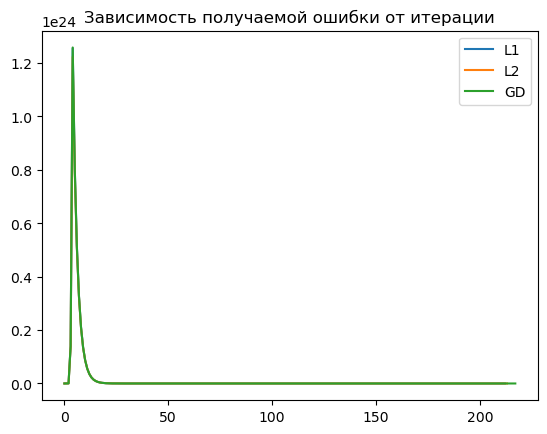

In [21]:
plt.plot(errors_l1, label='L1')
plt.plot(errors_l2, label='L2')
#plt.plot(errors_sgd, label='SGD')
plt.plot(errors_gd, label='GD')
plt.title('Зависимость получаемой ошибки от итерации')
plt.legend()
plt.show()

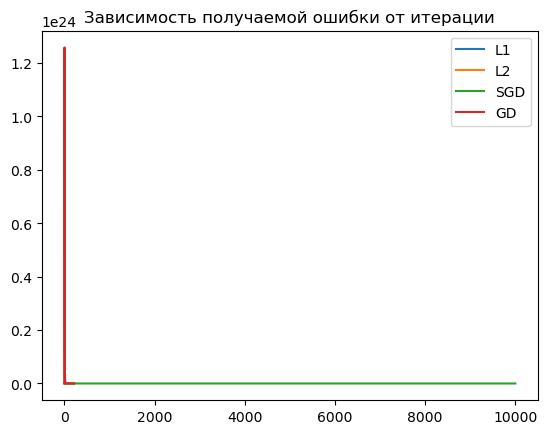

In [22]:
plt.plot(errors_l1, label='L1')
plt.plot(errors_l2, label='L2')
plt.plot(errors_sgd, label='SGD')
plt.plot(errors_gd, label='GD')
plt.title('Зависимость получаемой ошибки от итерации')
plt.legend()
plt.show()

### Вывод по разделу работы:
В результате работы было установлено, что хоть Стохастический градиентный спуск и потребляем меньше памяти и выполняется быстрее, в итоге для достижения результата необходимо гораздо больше шагов. В итоге mse и отклонения весов получаются с большой погрешностью.

### 3. Можно ли к одному и тому же признаку применить сразу и нормализацию, и стандартизацию?

Ответ: применить можно, но физического смысла в этом нет. Стандартизация необходима для масштабирования признаков при регрессиях, нормализация применяется при классификации

### 4. Постройте график зависимости весов всех признаков от lambda в L2-регуляризации на основе данных из урока.

In [29]:
lambda_ridge = []
list_w1 = []
list_w2 = []

list_lambda = np.linspace(1e-2, 1e2, 100)

for el in list_lambda:
    lambda_ridge.append(el)
    w, errors, w_step, time_t = gradient_descent_reg_l2(X_cutted, Y, eta=eta, reg = el)
    list_w1.append(w[0])
    list_w2.append(w[1])

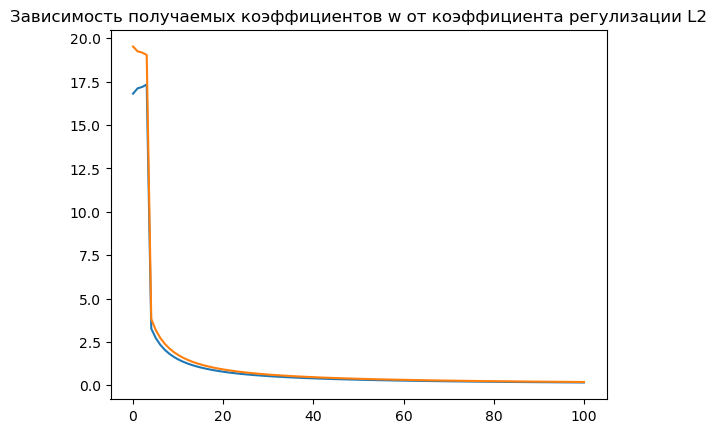

In [34]:
plt.plot(lambda_ridge, list_w1, label = 'w1')
plt.plot(lambda_ridge, list_w2, label = 'w2')
plt.legend
plt.title('Зависимость получаемых коэффициентов w от коэффициента регулизации L2')
plt.show()

### Вывод: чем больше коэффициент регулизации L2, тем ближе коэффициенты регрессии к истинному значению